In [1]:
import numpy as np
import time, datetime
import matplotlib.pyplot as plt
from collections import OrderedDict

import torch
import torch.nn as nn

In [2]:
# A useful utils we already used while training a FF network

def get_dict(net, to_numpy = True):
    if to_numpy:
        return OrderedDict(
            {k: v.detach().clone().to("cpu").numpy() for k, v in net.state_dict().items()}
        )
    else:
        return OrderedDict(
            {k: v.detach().clone().to("cpu") for k, v in net.state_dict().items()}
        )

# Let's wrap our network into a class

In [3]:
activations = {
    "sigmoid": torch.sigmoid,
    "tanh":    torch.tanh,
    "relu":    torch.relu,
    "linear":  lambda x: x
}

def get_act(nonlinearity):
    return activations[nonlinearity]

In [4]:
class Net(torch.nn.Module):
    
    def __init__(self, N = 10,
                 g = 1.,
                 num_in = 1,
                 num_out = 1,
                 nonlinearity = "tanh"):
        
        # init Module parent object
        super(Net, self).__init__()
        
        # set parameters
        self.N = N # number of neurons in the network
        self.num_in = num_in # number of input units
        self.num_out = num_out # number of output units
        self.act = get_act(nonlinearity) # define activation function
        
        # init weights and biases -> wrap in torch Parameter to access torch.nn.Module functionalities
        self.J = nn.Parameter(torch.randn(N, N) * g / np.sqrt(N)) # recurrent weights
        self.w_in = nn.Parameter(torch.randn(num_in, N)) # input weights
        self.w = nn.Parameter(torch.randn(N, num_out) / np.sqrt(N)) # output weights
        
        self.bias = nn.Parameter(torch.zeros(N)) # single-neuron biases
        self.bias_w = nn.Parameter(torch.zeros(num_out)) # output biases
        
    def forward(self, dt, inp, x0=None):
        
        # init records
        titot, batch_size = inp.shape[:2]
        xs = torch.zeros(titot, batch_size, self.N)
        zs = torch.zeros(titot, batch_size, self.num_in)
        
        # init net
        x = x0 if x0 is not None else torch.zeros(batch_size, self.N)
        
        # run
        for ti in range(titot):
            r = self.act(x)
            x = (1. - dt) * x + dt * r @ self.J.T + dt * self.bias
            x += dt * inp[ti] * self.w_in
            z = r @ self.w + self.bias_w
            xs[ti] = x
            zs[ti] = z
        
        return xs, x, zs

## Init network

In [17]:
N = 50
g_init = 1.2
num_in = 1
num_out = 1
nonlinearity = "tanh"

net = Net(N=N,
          g=g_init,
          num_in=num_in,
          num_out=num_out,
          nonlinearity=nonlinearity)

## Test spontaneous activity in untrained network

In [18]:
# run test
dt = 0.1
titot_test = 2000
num_tests = 2
inp = torch.zeros((titot_test, num_tests, num_in))

with torch.no_grad():
    x0 = torch.randn(num_tests, N)
    xs, x, zs = net(dt, inp, x0=x0)

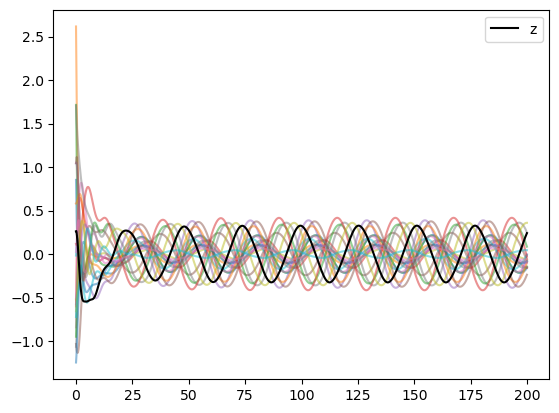

In [19]:
# plot records
mu = 1 # note that we ran num_tests experiments all at once
ts = np.arange(titot_test) * dt
plt.plot(ts, xs[:,mu,:20], alpha=0.5);
plt.plot(ts, zs[:,mu], color='black', label='z');
plt.legend();

# Set task

We'll ask the network to produce a self-substained oscillation

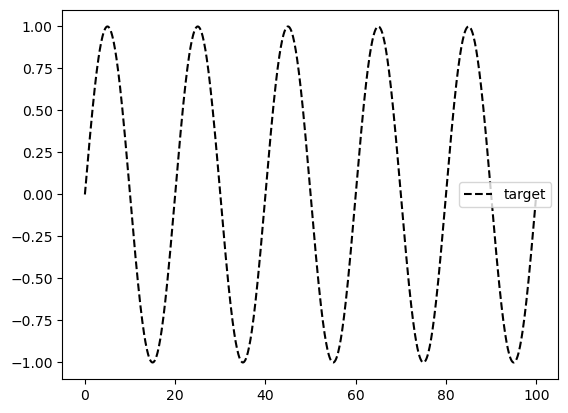

In [20]:
# We will ask the readout to reproduce an oscillation with a fixed frequency

def target_func(t, freq = 0.05):
    return torch.sin(2 * np.pi * freq * t) # WARNING: Here we're using torch.sin

# take a look at the target function
ts = torch.arange(0, 100, dt) # WARNING: Here we're using torch.arange
plt.plot(ts, target_func(ts), '--', color="black", label="target");
plt.legend();

## Let's write a test function

When we're trying to train a stable dynamics the notion of generalization is the following:
- generalization to unseen initial conditions x0
- and stability to perturbations

More generally, we will ask the network to generalize its response properties to unseen inputs, just like we saw in the feed-forward case with static images: this is what you will experiment in the Assignment!

In [21]:
def test(model, zs_desired,
         x0 = None,
         num_tests = 1,
         titot_test = 1,
         dt = 1):
        
    err = 0
    loss = 0.
    inp = torch.zeros((titot_test, num_tests, num_in))
    if x0 is None:
        x0 = torch.randn(num_tests, N)
    with torch.no_grad():
        xs, x, zs = net(dt, inp, x0=x0)
        err = ((zs[:,:,0] - zs_desired[:,None])**2).mean()
    return xs, zs, err

### Test the test function (literally a meta test)

test error: tensor(0.5612)


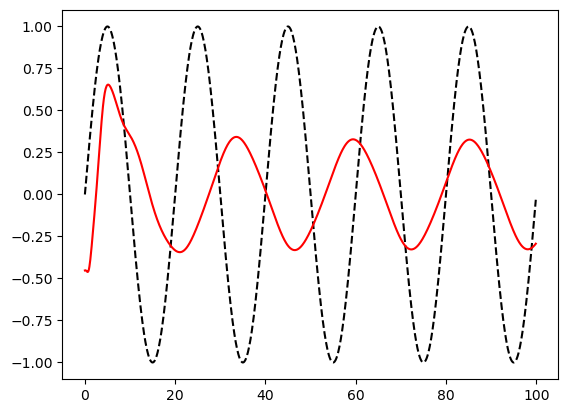

In [22]:
num_tests = 10
titot_test = 1000

ts_test = torch.arange(titot_test) * dt
zs_desired_test = target_func(ts_test)
xs, zs_test, err_test = test(net, zs_desired_test, num_tests=10, titot_test=titot_test, dt=0.1)

mu = 0
plt.plot(ts_test, zs_desired_test, '--', color="black", label="target");
plt.plot(ts_test, zs_test[:,mu,0], '-', color="red", label="z");

print("test error:", err_test)

# Train

## set training parameters and optimizer

In [23]:
dt = 0.1
titot_train = 1000
titot_test = 500

batch_size = 1
num_epochs = 1000
test_every = 20
# optimizer = 'SGD'
optimizer = 'Adam'
lr = 1e-3
momentum = 0.

loss_fn = nn.MSELoss(reduction="mean")

In [24]:
to_train = net.parameters() # train all parameters

if optimizer == 'SGD':
    opt = torch.optim.SGD(to_train, lr=lr, momentum=momentum)
elif optimizer == 'Adam':
    opt = torch.optim.Adam(to_train, lr=lr)
elif optimizer == 'RMSprop':
    opt = torch.optim.RMSprop(to_train, lr=lr)

## start training

In [25]:
# To keep things simple, let's only train with a given initial condition
x0_start = 1e-1 * torch.randn(batch_size, N)

In [26]:
# init containers and variables
losses, losses_ep = [], []
errs_train, errs_test, eps_test = [], [], []
best_err_train, best_err_test = 1e10, 1e10
best_net_train, best_net_test = None, None

# utilities to measure time
start_time = time.time()
start_time_total = time.time()

inp = torch.zeros((titot_train, batch_size, num_in))
ts_train = ts_test = torch.arange(titot_train) * dt
zs_desired_train = target_func(ts_train)

In [27]:
# start testing right after training phase

ts_test = ts_train[-1] + dt + torch.arange(titot_test) * dt
zs_desired_test = target_func(ts_test)

# # and that's how it looks like (make sure to comment the following lines after checking them out)
# plt.plot(ts_train, zs_desired_train, label="train");
# plt.plot(ts_test, zs_desired_test, label="test");
# plt.legend();

In [28]:
# train
for ep in range(1, num_epochs+1):
 
    x0 = x0_start + torch.randn_like(x0_start) * 1e-10 # check out what happens perturbing initial conditions
    xs, x, zs = net(dt, inp, x0=x0)

    # compute loss
    loss = ((zs[:,:,0] - zs_desired_train[:,None])**2).mean()

    # backpropagate and update weights
    opt.zero_grad()
    loss.backward()
    opt.step()

    # exit if NaN loss
    if np.isnan(loss.item()):
        raise ValueError("NaN happened")

    # record loss
    losses += [loss.item()]

    # compute err & test
    err_test = np.nan
    if ep % test_every == 0:
        
        # measure time and print loss
        elapsed_time = time.time() - start_time
        start_time = time.time()
        eps_test += [ep]
        toprint = 'ep: {} time: {:.2f} Loss: {:.4f}'.format(ep, elapsed_time/60, loss.item())

        # check if improved train
        improved_train = loss < best_err_train
        if improved_train:
            best_err_train = loss
            best_net_train = get_dict(net)

        # test network
        xs_test, zs_test, err_test = test(net, zs_desired_test,
                                          x0=x, # avoid a phase offset due to random initial conditions
                                          num_tests=x.shape[0], titot_test=titot_test, dt=dt)
        
        toprint += ' g: {:.4f}'.format(err_test)
        errs_test.append(err_test)
        # check if improved test
        improved_test = err_test < best_err_test
        if improved_test:
            best_err_test = err_test
            best_net_test = get_dict(net)

        # print if improved
        if improved_train:
            toprint += u' \u2193'
        if improved_test:
            toprint += u' *'

        print(toprint)
        
elapsed_time = time.time() - start_time_total
print("done")
print("elapsed:", str(datetime.timedelta(seconds=elapsed_time)))

ep: 20 time: 0.11 Loss: 0.2680 g: 0.5172 ↓ *
ep: 40 time: 0.07 Loss: 0.0331 g: 0.0373 ↓ *
ep: 60 time: 0.07 Loss: 0.0169 g: 0.0076 ↓ *
ep: 80 time: 0.06 Loss: 0.0121 g: 0.0048 ↓ *
ep: 100 time: 0.06 Loss: 0.0093 g: 0.0022 ↓ *


KeyboardInterrupt: 

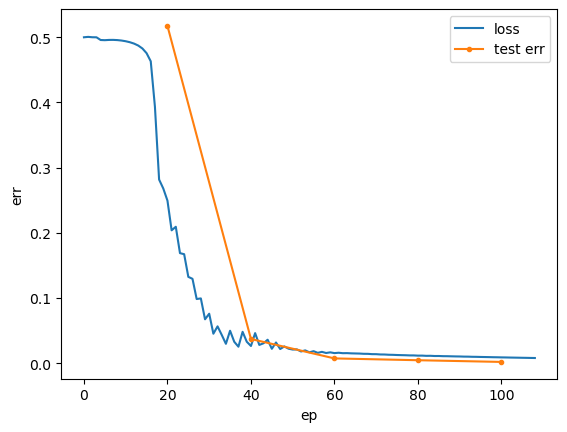

In [29]:
plt.plot(losses, label="loss");
plt.plot(eps_test, errs_test, '.-', label="test err");
plt.xlabel("ep");
plt.ylabel("err")
plt.legend();

Let's take a look at the last training and test session

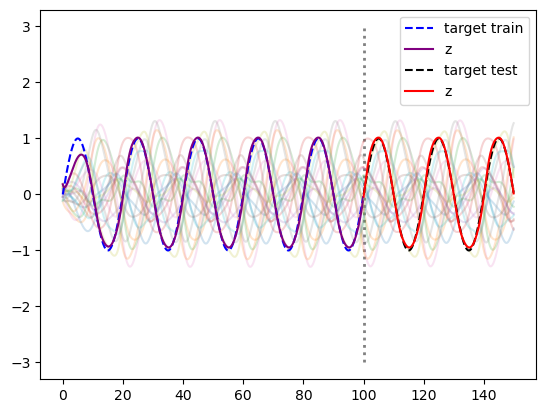

In [30]:
mu = 0
plt.plot(ts_train, xs[:,mu,:20].detach(), alpha=0.2);
plt.plot(ts_train, zs_desired_train, '--', color="blue", label="target train");
plt.plot(ts_train, zs[:,mu,0].detach(), '-', color="purple", label="z");

plt.vlines(x=ts_test[0], ymin=-3, ymax=3, lw=2, color='gray', ls=':');

plt.plot(ts_test, xs_test[:,mu,:20].detach(), alpha=0.2);
plt.plot(ts_test, zs_desired_test, '--', color="black", label="target test");
plt.plot(ts_test, zs_test[:,mu,0], '-', color="red", label="z");
plt.legend();

Try to test with random initial conditions now

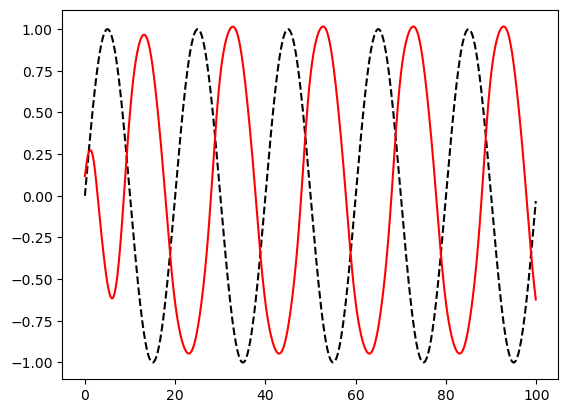

In [40]:
num_tests = 1
titot_test = 1000

ts_test = torch.arange(titot_test) * dt
zs_desired_test = target_func(ts_test)
xs_test, zs_test, err_test = test(net, zs_desired_test, num_tests=10, titot_test=titot_test, dt=0.1)

plt.plot(ts_test, zs_desired_test, '--', color="black", label="target");
plt.plot(ts_test, zs_test[:,1,0], '-', color="red", label="z");

# print("test error:", err_test.item()) # test error doesn't really makes sense
# ...unless one uses a matching algorithm

# Assignments

1. Implement a sine with input-modulated frequency

2. OPTIONAL: Can you train a network composed of two distinct Excitatory and Inhibitory populations? Use a relu activation and enforce sign-constraints.

3. ADVANCED: Recurrent networks can be used as classifiers. Can you set up the problem and train a network to classify MNIST digist?

## Some help with assignment 1:

1. Use dataloaders (like we did in ff_bptt notebook) to feed random input-output batches to the network

2. Ask the instructor for help for anything else

## Some help with assignment 2:

1. An EI separated initializiation is not enough!

2. Start from a stable network by adjusting the stability of the (not necessarily zero) fixed point

## Some help with assignment 3:

Take some time to think about how an unrolled recurrent network is equivalent to a deep network with the same weights across layers ... in case of need, ask the instructor for help in real life or on Discord.